<a href="https://colab.research.google.com/github/sriram403/MachineLearningBlogs/blob/main/Tom%20And%20Jerry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import DataSet From Kaggle

In [74]:
# !pip install kaggle

In [75]:
##Import the kaggle Api tokken file from your kaggle account
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"adithiyacommon","key":"d7fef4f0e86f383df9534e4b921bd5fb"}'}

If you don't know what is kaggle api tokken just watch this 
https://www.youtube.com/watch?v=57N1g8k2Hwc

In [76]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [77]:
!cp kaggle.json ~/.kaggle/

In [78]:
!chmod 600 ~/.kaggle/kaggle.json

In [79]:
!kaggle datasets download -d balabaskar/tom-and-jerry-image-classification

tom-and-jerry-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extracting the zipfile downloaded from kaggle

In [80]:
import zipfile 
zip = zipfile.ZipFile("/content/tom-and-jerry-image-classification.zip")
zip.extractall()
zip.close()

In [81]:
dir = "/content/tom_and_jerry/tom_and_jerry/"

## Creating Training And Validation dataset

In [82]:
import tensorflow as tf
train_df= tf.keras.utils.image_dataset_from_directory(dir,color_mode="rgb",
                                                              validation_split=0.2,
                                                              seed=42,
                                                              subset="training",
                                                              image_size=(224,224))
train_df

Found 5478 files belonging to 4 classes.
Using 4383 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [84]:
valid_df = tf.keras.preprocessing.image_dataset_from_directory(dir,image_size=(224,224),
                                                               validation_split=0.2,seed=42,
                                                               subset="validation",color_mode="rgb")
valid_df

Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## DataSet View

In [83]:
for images,labels in train_df.take(1):
  print(images.shape)
  print(labels.shape)

(32, 224, 224, 3)
(32,)


In [85]:
class_names = train_df.class_names
class_names

['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

In [86]:
import matplotlib.pyplot as plt
import matplotlib.image as mpim

In [87]:
image = train_df.take(1)
image

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [88]:
for images,label in image:
  print(images.shape)

(32, 224, 224, 3)


In [89]:
images[0].shape

TensorShape([224, 224, 3])

In [90]:
len(images)

32

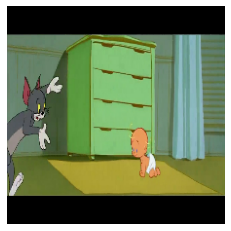

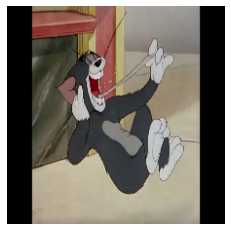

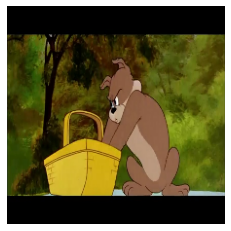

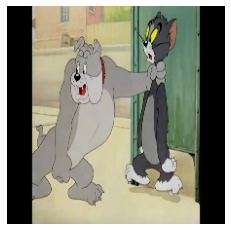

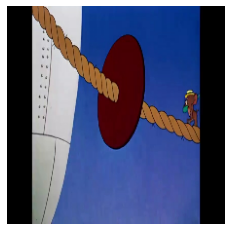

In [91]:
import random
for i in range(5):
  r_i = random.randint(0,len(images))
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.axis(False);
  plt.show()

In [92]:
class_names

['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

## Preparing our dataset for parallel processing(not utilize free gpu google colab provide)

In [93]:
train_data = train_df.shuffle(buffer_size=10000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data = valid_df.prefetch(buffer_size=tf.data.AUTOTUNE)

##Base_Models

In [94]:
base_model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(10,5,activation="relu",input_shape=(224,224,3)),
                             tf.keras.layers.Conv2D(10,5,activation="relu"),
                             tf.keras.layers.MaxPool2D(pool_size=2,padding='valid'),
                             tf.keras.layers.Conv2D(10,kernel_size=5,activation="relu"),
                             tf.keras.layers.Conv2D(10,kernel_size=5,activation="relu"),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(100,activation="relu"),
                             tf.keras.layers.Dense(len(class_names),activation="softmax")])


base_model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
base_model_history = base_model.fit(train_data,epochs=3,steps_per_epoch=len(train_data),
                                    validation_data=valid_data,validation_steps=len(valid_data))

Epoch 1/3
137/137 [==============================] - 21s 67ms/step - loss: 15.1053 - accuracy: 0.4237 - val_loss: 1.2115 - val_accuracy: 0.4603
Epoch 2/3
137/137 [==============================] - 19s 64ms/step - loss: 0.8594 - accuracy: 0.6553 - val_loss: 0.8313 - val_accuracy: 0.6795
Epoch 3/3
137/137 [==============================] - 19s 65ms/step - loss: 0.5275 - accuracy: 0.8070 - val_loss: 0.7776 - val_accuracy: 0.7178


### Plotting loss curve 

In [95]:
def plot_history(history):
  loss = history.history["loss"]
  accuracy = history.history["accuracy"]

  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]

  plt.figure(figsize=(10,7))
  plt.plot(loss,label="loss")
  plt.plot(val_loss,label="val_loss")
  plt.legend()

  plt.figure(figsize=(10,7))
  plt.plot(accuracy,label="accuracy")
  plt.plot(val_accuracy,label="val_accuracy")
  plt.legend()

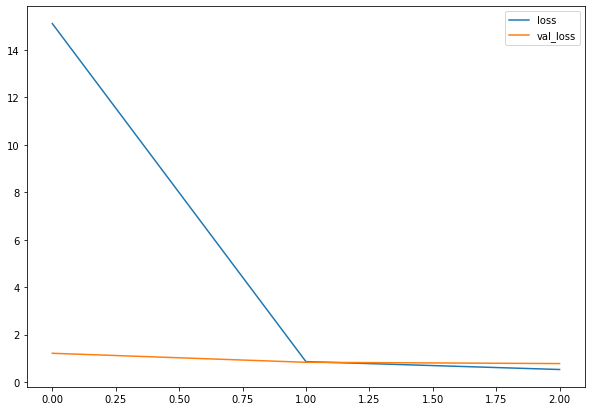

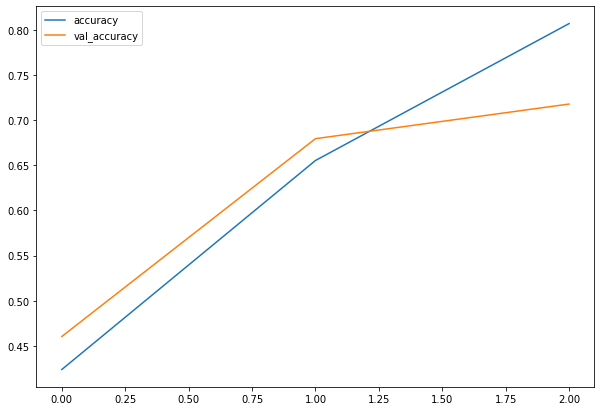

In [96]:
plot_history(base_model_history)

## Creating DataAugmentation Layer

In [97]:
data_aug = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomContrast(0.4),
                                tf.keras.layers.experimental.preprocessing.RandomFlip(),
                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
                                tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
                                tf.keras.layers.experimental.preprocessing.RandomContrast(0.5)])

##Model_1

In [98]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
In = tf.keras.layers.Input(shape=(224,224,3))
Data_Aug = data_aug(In)
x = base_model(Data_Aug)
pool = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(class_names),activation="softmax")(pool)
model_1 = tf.keras.Model(In,output)
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_____________________________________________

### Fine Tuning Our Model

In [99]:
model_1.layers[1].trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [100]:
# for layer in base_model.layers:
#   print(layer.name,layer.trainable)

In [101]:
model_1.compile(loss = "sparse_categorical_crossentropy",
                optimizer="adam",
                metrics="accuracy")
model_1_history = model_1.fit(train_data,epochs=5,steps_per_epoch=len(train_data),
                              validation_data=valid_data,validation_steps=len(valid_data))

Epoch 1/5
137/137 [==============================] - 30s 107ms/step - loss: 1.1537 - accuracy: 0.4978 - val_loss: 0.9880 - val_accuracy: 0.5927
Epoch 2/5
137/137 [==============================] - 25s 98ms/step - loss: 0.9610 - accuracy: 0.6105 - val_loss: 0.9372 - val_accuracy: 0.6018
Epoch 3/5
137/137 [==============================] - 23s 99ms/step - loss: 0.9043 - accuracy: 0.6292 - val_loss: 0.8296 - val_accuracy: 0.6584
Epoch 4/5
137/137 [==============================] - 25s 98ms/step - loss: 0.8524 - accuracy: 0.6642 - val_loss: 0.7887 - val_accuracy: 0.6868
Epoch 5/5
137/137 [==============================] - 23s 98ms/step - loss: 0.8156 - accuracy: 0.6778 - val_loss: 0.7810 - val_accuracy: 0.6849


### Plotting Loss Curve

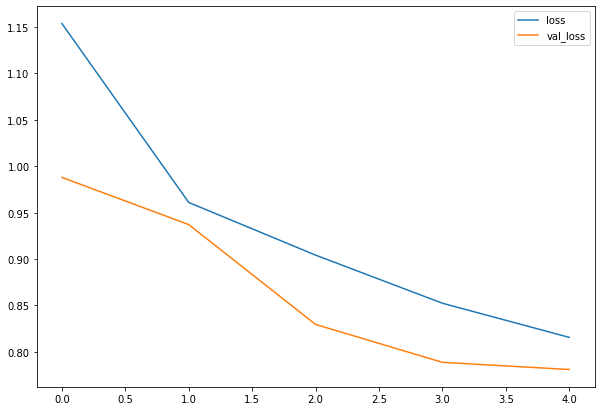

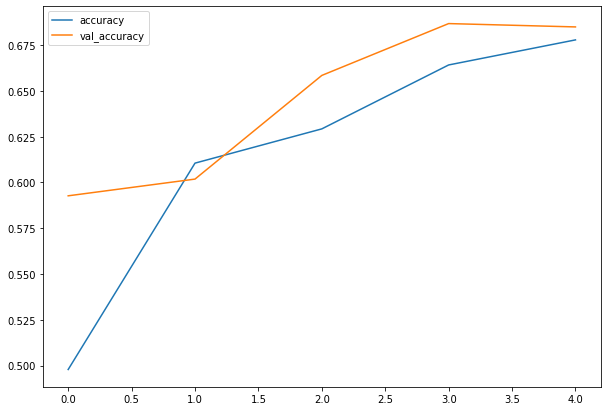

In [102]:
plot_history(model_1_history)

## Saving Our model

In [104]:
import pickle
pickle.dump(model_1,open("mark_3","wb"))

In [105]:
import pickle
loaded_model = pickle.load(open("/content/drive/MyDrive/mark_3","rb"))
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_______________________________________________

## Tom And Jerry Final

In [106]:
def getting_image_data(dir,is_norm=False):
  img_dir = tf.io.read_file(dir)
  img_data = tf.io.decode_image(img_dir)
  img_shape = tf.image.resize(img_data,size=(224,224))
  if is_norm:
    return img_shape/255
  else:
    return img_shape

In [111]:
def predict_tom_jerry(image_file,class_names,model,is_ax):
  img = getting_image_data(image_file,False)
  pred = model.predict(tf.expand_dims(img,axis=0))
  pred_prob = pred.max()
  c_n = class_names[pred[0].argmax()]
  if is_ax:
    return c_n,img
  else:
    plt.imshow(img/255)
  plt.axis(False)
  plt.title(f"{c_n} {pred_prob:.2f} %")

🛑 Drag and drop the image in the files section

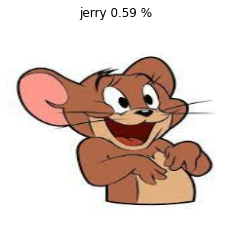

In [125]:
# # for testing your custom image :-)
class_names = ['jerry', 'tom', 'There is no tom or jerry', 'It\'s Tom And Jerry']
import tensorflow as tf
import matplotlib.pyplot as plt
image_name = "/content/download.jpg"
predict_tom_jerry(image_name,class_names,loaded_model,False);